In [23]:
pip install opencv-python numpy

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


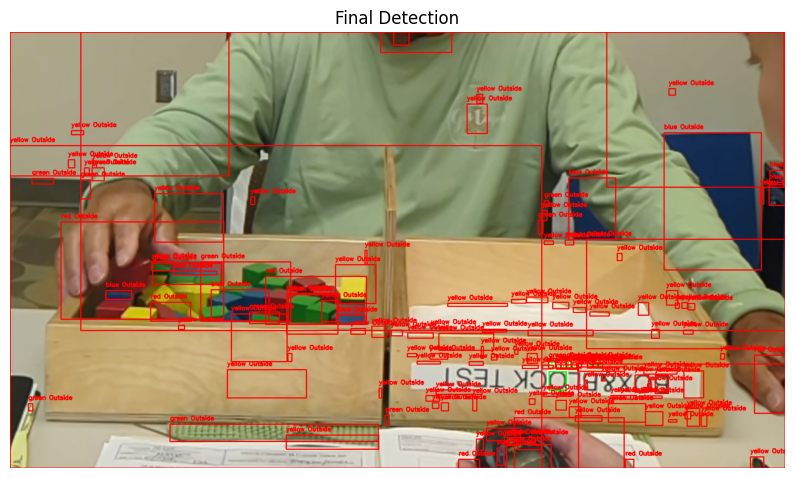

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_wooden_box_edges(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    box_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(box_contour)

    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.putText(frame, "Wooden Box", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return (x, y, w, h), frame


def detect_blocks_outside_box(frame, box_edges):
    box_x, box_y, box_w, box_h = box_edges

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    color_ranges = {
        "red": ((0, 50, 50), (10, 255, 255)),
        "green": ((35, 50, 50), (85, 255, 255)),
        "blue": ((90, 50, 50), (130, 255, 255)),
        "yellow": ((20, 50, 50), (30, 255, 255)),
    }

    for color, (lower, upper) in color_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 50:
                x, y, w, h = cv2.boundingRect(contour)
                block_center_x = x + w // 2
                block_center_y = y + h // 2

                if (
                    block_center_x < box_x
                    or block_center_x > box_x + box_w
                    or block_center_y < box_y
                    or block_center_y > box_y + box_h
                ):
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
                    cv2.putText(
                        frame,
                        f"{color} Outside",
                        (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 0, 255),
                        2,
                    )
                else:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 2)
                    cv2.putText(
                        frame,
                        f"{color} Inside",
                        (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 255, 255),
                        2,
                    )

    return frame


def main():
    image_path = '/content/drive/My Drive/frame_0000.jpg'

    frame = cv2.imread(image_path)

    if frame is None:
        print("Error: Could not load the image.")
        return

    box_edges, frame_with_box = detect_wooden_box_edges(frame)

    final_frame = detect_blocks_outside_box(frame_with_box, box_edges)

    final_frame_rgb = cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(final_frame_rgb)
    plt.axis("off")
    plt.title("Final Detection")
    plt.show()


if __name__ == "__main__":
    main()


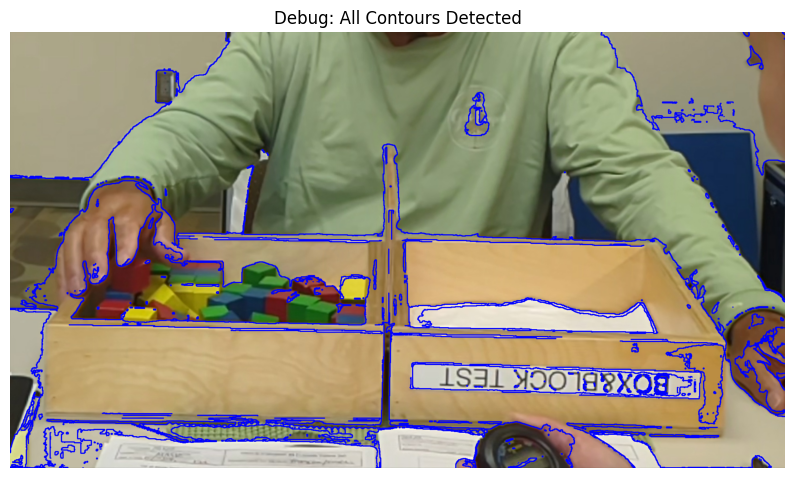

No wooden box detected. Consider adjusting HSV range or thresholds.


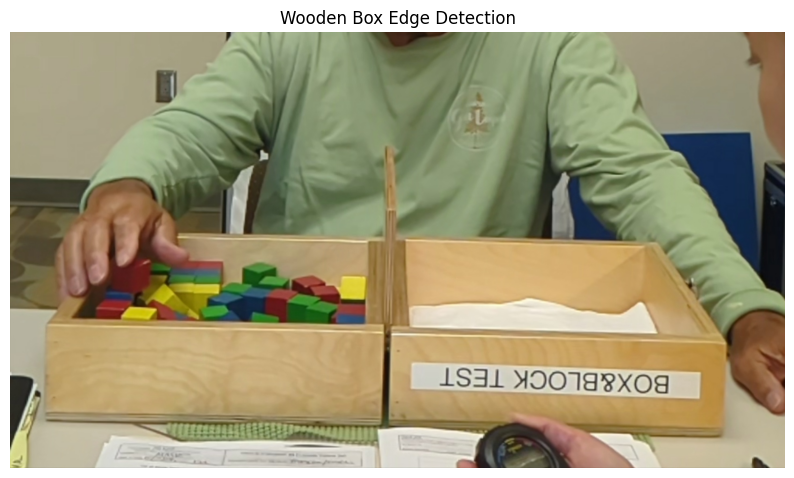

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# HSV range based on the wooden color
lower_wooden = np.array([5, 40, 120])
upper_wooden = np.array([35, 160, 255])

def detect_wooden_box_edges(frame, debug=False):
    """
    Detects edges of the wooden box and highlights it, with debugging options.
    """
    # Convert to HSV for color filtering
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Mask for the wooden color
    mask = cv2.inRange(hsv, lower_wooden, upper_wooden)

    # Apply the mask to keep only the wood colored regions
    filtered_frame = cv2.bitwise_and(frame, frame, mask=mask)

    gray = cv2.cvtColor(filtered_frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if debug:
        debug_frame = frame.copy()
        cv2.drawContours(debug_frame, contours, -1, (255, 0, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(debug_frame, cv2.COLOR_BGR2RGB))
        plt.title("Debug: All Contours Detected")
        plt.axis("off")
        plt.show()

    wooden_box_contour = None
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        aspect_ratio = w / h
        if 1.5 < aspect_ratio < 4.0 and area > 1000:
            if area > max_area:
                wooden_box_contour = contour
                max_area = area

    if wooden_box_contour is not None:
        # Bounding box around the wooden box
        x, y, w, h = cv2.boundingRect(wooden_box_contour)

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(frame, "Wooden Box", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    else:
        print("No wooden box detected. Consider adjusting HSV range or thresholds.")

    return frame


def main():
    image_path = '/content/drive/My Drive/frame_0000.jpg'

    frame = cv2.imread(image_path)

    if frame is None:
        print("Error: Could not load the image.")
        return

    frame_with_box = detect_wooden_box_edges(frame, debug=True)

    frame_rgb = cv2.cvtColor(frame_with_box, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title("Wooden Box Edge Detection")
    plt.show()


if __name__ == "__main__":
    main()
